In [40]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from statsmodels.tsa.arima_model import ARIMA
import warnings
import itertools
from pmdarima.arima.utils import nsdiffs, ndiffs
import pmdarima as pm

warnings.filterwarnings("ignore")

In [27]:
def parametersearch(data, p=[1,2,3,4,5], d=[0,1,2], q=[1,2,3,4]):
    aic = 100000000
    order=None
    combination = list(itertools.product(p, d, q))
    for comb in combination:
        try:
            model = ARIMA(data, order=comb)
            model_fit = model.fit(disp=0)
            if model_fit.aic < aic:
                aic = model_fit.aic
                order = comb
        except Exception as e:
            pass;
        
    return order

def plot_prediction(train, test, order, size=50):
    model = ARIMA(train, order)  
    fitted = model.fit(disp=0)  

    # Forecast
    fc, se, conf = fitted.forecast(size, alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    if len(train)>500:
        plt.plot(train[len(train)-500:], label='training')
    else:
        plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    #plt.fill_between(lower_series.index, lower_series, upper_series, 
    #                 color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
def metrics_prediction(train, test, order, size=50):
    
    model = ARIMA(train, order)  
    fitted = model.fit(disp=0) 
    
    fc, se, conf = fitted.forecast(size, alpha=0.05)
    
    mpe = np.mean((fc - test)/test)
    mae = np.mean(np.abs(fc - test))
    rmse = np.mean((fc - test)**2)**.5
    
    return {'mpe':mpe,
            'mae':mae,
            'rmse':rmse
           }

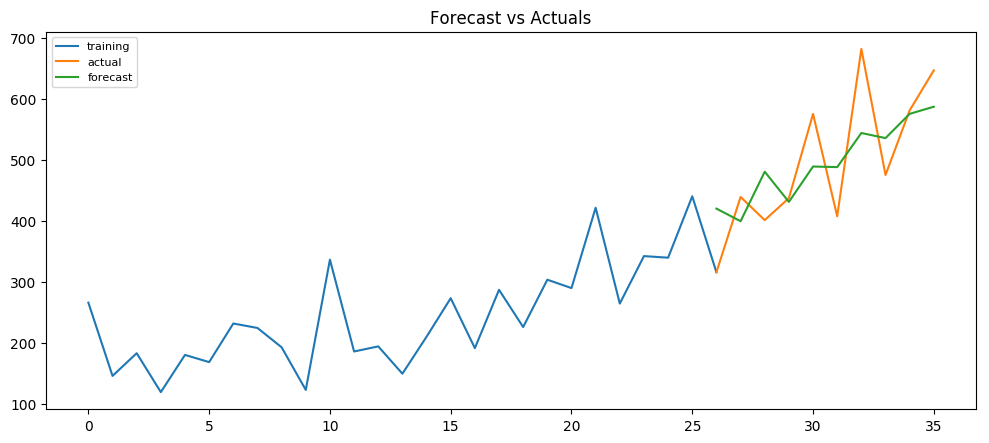

In [28]:
# Func to turn date legible.
def adjust_year(year):
    adjust = year.split('-');
    return str(adjust[1]+'-'+str(int(adjust[0])+2015) )

# Units solds by shampoo branding
shampoo = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv');
shampoo['Date'] = pd.to_datetime(shampoo['Month'].apply(adjust_year), format='%m-%Y')
shampoo = shampoo[['Date', 'Sales']]


train = shampoo.Sales[:27]; test = shampoo.Sales[26:];
order = parametersearch(train)
plot_prediction(train, test, order, 10)
shampoo_metrics = metrics_prediction(train, test, order, 10)

In [29]:
print('parameters: ', order)
print('metrics: ', shampoo_metrics)

parameters:  (4, 2, 1)
metrics:  {'mpe': 0.02942039775958452, 'mae': 66.03321131672075, 'rmse': 76.81315470925041}


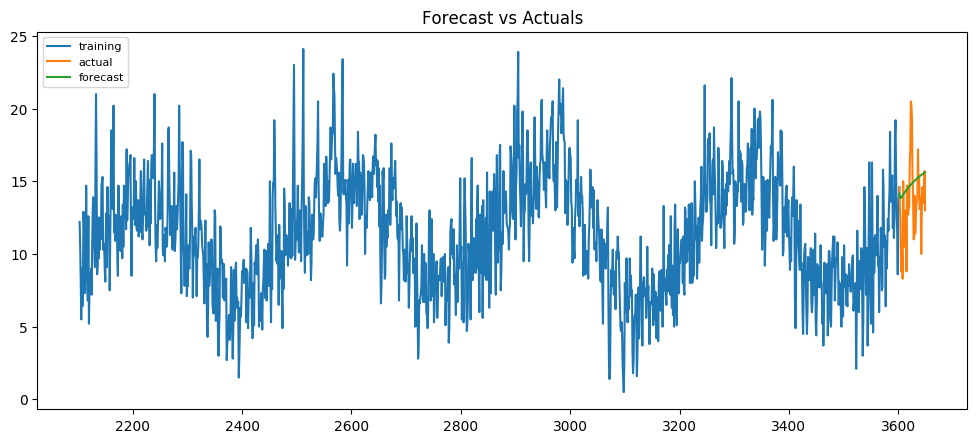

In [30]:
temperature = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv')
temperature['Date'] = pd.to_datetime(temperature['Date'])
temperature = temperature.fillna(0.0)


train = temperature.Temp[:len(temperature.Temp)-47]; test = temperature.Temp[len(temperature.Temp)-48:];
order = parametersearch(train)

plot_prediction(train, test, order,48)
dailytmp_metrics = metrics_prediction(train, test, order, 48)

In [32]:
print('parameters: ', order)
print('metrics: ', dailytmp_metrics)

parameters:  (4, 1, 2)
metrics:  {'mpe': 0.13417283205201028, 'mae': 2.302292181143918, 'rmse': 2.819039625929829}


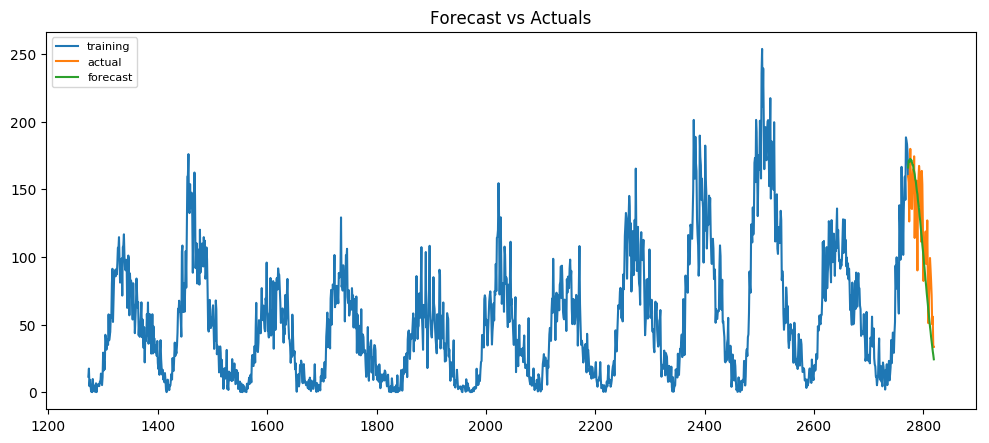

In [33]:
sunspot = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv')
sunspot['Date'] = pd.to_datetime(sunspot['Month']); sunspot= sunspot[['Date', 'Sunspots']]


train = sunspot.Sunspots[:len(sunspot.Sunspots)-47]; test = sunspot.Sunspots[len(sunspot.Sunspots)-48:];
order = parametersearch(train)

plot_prediction(train, test, order,48)
monthlysuntmp_metrics = metrics_prediction(train, test, order, 48)

In [34]:
print('parameters: ', order)
print('metrics: ', monthlysuntmp_metrics)

parameters:  (5, 0, 4)
metrics:  {'mpe': -0.08253252192298186, 'mae': 23.272573455081314, 'rmse': 27.761651863903182}


#### SARIMA

In [49]:
#Get number of diffs
def get_SARIMA(train):
    n_adf = ndiffs(train, test='adf')

    smodel = pm.auto_arima(train, start_p=1, max_p=5,
                                 test='adf', d=n_adf,
                                 start_q=1, max_q=5,
                                 seasonal=True, m=12,
                                 start_P=1, max_P=5,
                                 D=n_adf,
                                 start_Q=1, max_Q=5,
                                 trace=False,
                                 error_action='ignore',  
                                 suppress_warnings=True, 
                                 stepwise=True)

    return smodel

def metrics_prediction_SARIMA(model, test, size=50):
        
    fc = model.predict(size)
    
    mpe = np.mean((fc - test)/test)
    mae = np.mean(np.abs(fc - test))
    rmse = np.mean((fc - test)**2)**.5
    
    return {'mpe':mpe,
            'mae':mae,
            'rmse':rmse
           }

def plot_prediction_SARIMA(model, test, size=50):
 
    # Forecast
    fc = model.predict(size)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test.index)
    
    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    if len(train)>1500:
        plt.plot(train[len(train)-1500:], label='training')
    else:
        plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    

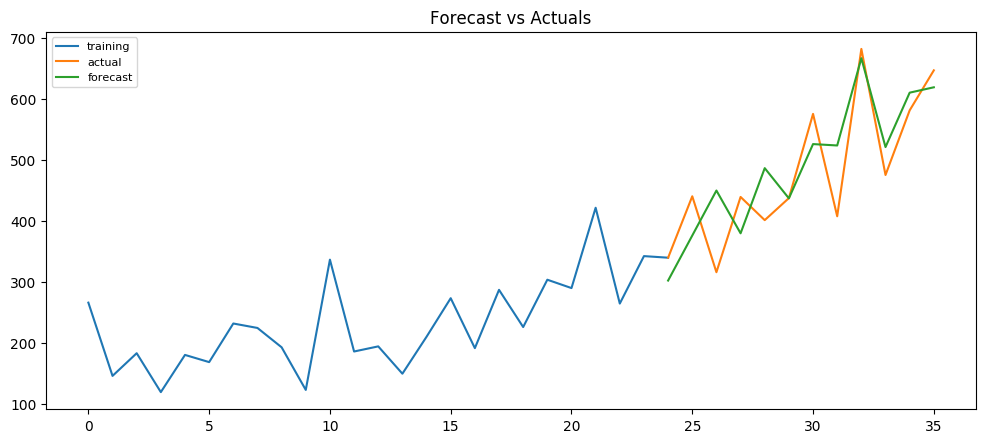

In [45]:
train = shampoo.Sales[:25]; test = shampoo.Sales[24:];
shampoo_model = get_SARIMA(train)
plot_prediction_SARIMA(shampoo_model, test, 12)

In [46]:
metrics_prediction_SARIMA(shampoo_model, test, 12)

{'mpe': 0.04360005796017863,
 'mae': 55.3697382471538,
 'rmse': 67.19432721058045}

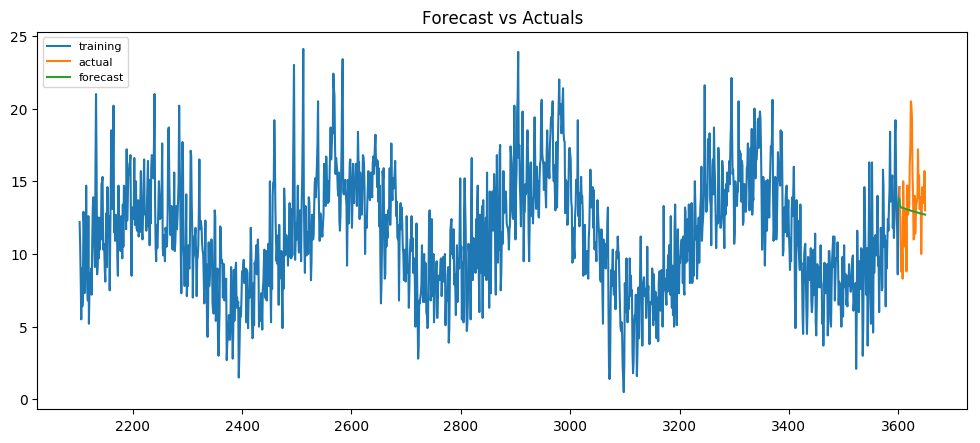

In [50]:
train = temperature.Temp[:len(temperature.Temp)-47]; test = temperature.Temp[len(temperature.Temp)-48:];
temp_model = get_SARIMA(train)
plot_prediction_SARIMA(temp_model, test, 48)

In [51]:
metrics_prediction_SARIMA(temp_model, test, 48)

{'mpe': -0.0024802567141230156,
 'mae': 1.9998800851769687,
 'rmse': 2.7155533444409143}

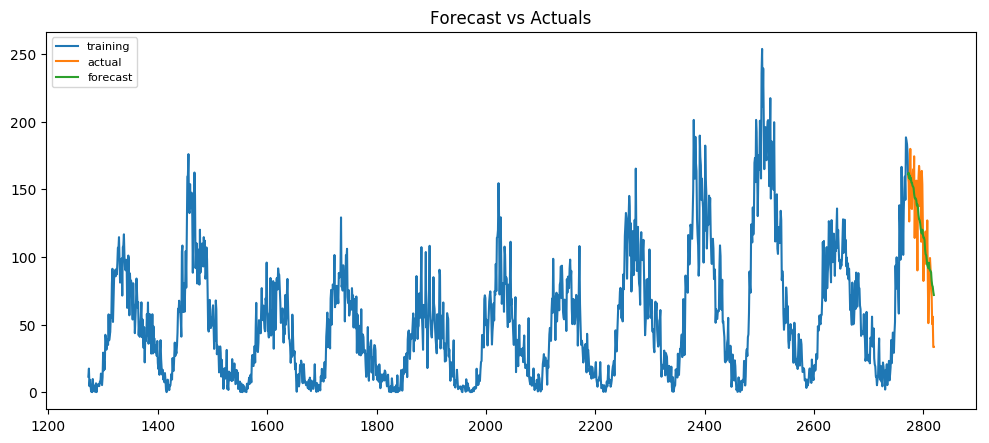

In [52]:
train = sunspot.Sunspots[:len(sunspot.Sunspots)-47]; test = sunspot.Sunspots[len(sunspot.Sunspots)-48:];
sunspot_model = get_SARIMA(train)
plot_prediction_SARIMA(sunspot_model, test, 48)

In [53]:
metrics_prediction_SARIMA(sunspot_model, test, 48)

{'mpe': 0.09793313022296517,
 'mae': 17.85387685717373,
 'rmse': 22.73365356997313}

### LSTM

In [54]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Bidirectional
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [94]:
def split_dataset(train, temp=12):
    x_values=[]
    y_values=[]
    
    for i in range(0, len(train)-temp-2):
        xval = train[i:i+temp]
        yval = train[i+temp+1]
        
        x_values.append(xval)
        y_values.append(yval)
        
    return (array(x_values), array(y_values))

### Model Design
def model_design_LSTM(X, y, n_steps=12):
    n_features = 1;    
    
    X_val = X.reshape((X.shape[0], X.shape[1], n_features))
    
    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    
    model.fit(X_val, y, epochs=400, verbose=0)
    return model


### Predict
def predict_LSTM(train, model, window_learn=12, window_pred=48):
    
    predict=[]
    start = xtrain[len(xtrain)-1].tolist()
    
    for index in range(0, window_pred):
        x_input = array(start)
        x_input = x_input.reshape((1, window_learn, 1))
        yhat = model.predict(x_input, verbose=0)[0][0]
        
        ##predict
        predict.append(yhat)
        
        ##refresh buffer input
        start = start[1:]; start.append(yhat)
        
    return predict


def plot_prediction_LSTM(fc, test):
 

    # Make as pandas series
    fc_series = pd.Series(fc, index=test.index)
    
    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    if len(train)>1500:
        plt.plot(train[len(train)-1500:], label='training')
    else:
        plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
def metrics_LSTM(predict, test):
    
    mpe = np.mean((predict - test)/test)
    mae = np.mean(np.abs(predict - test))
    rmse = np.mean((predict - test)**2)**.5
    
    return {'mpe':mpe,
            'mae':mae,
            'rmse':rmse
           }


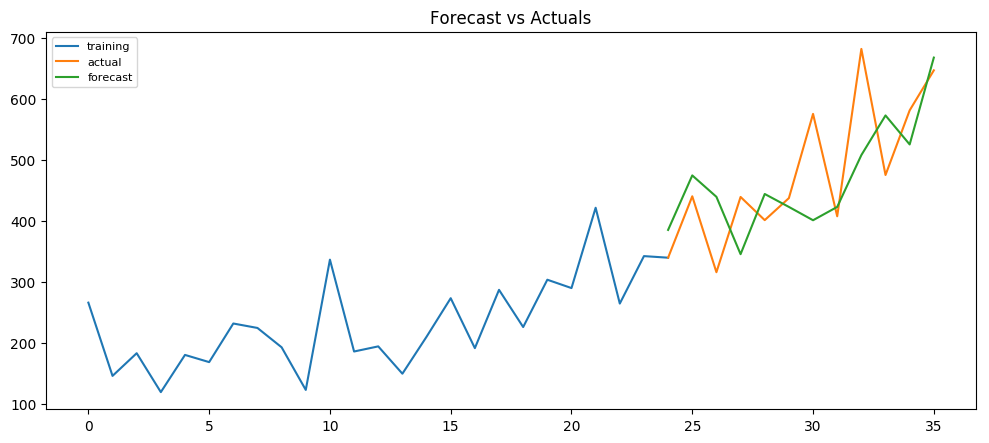

In [98]:
train = shampoo.Sales[:25]; test = shampoo.Sales[24:];
xtrain, ytrain = split_dataset(train) 
model = model_design_LSTM(xtrain, ytrain)
plot_prediction_LSTM(predict_LSTM(xtrain, model, 12, 12), test)

In [99]:
print(metrics_LSTM(predict_LSTM(xtrain, model, 12, 12), test))

{'mpe': 0.007019788362288414, 'mae': 74.3949971516927, 'rmse': 92.83137680811532}


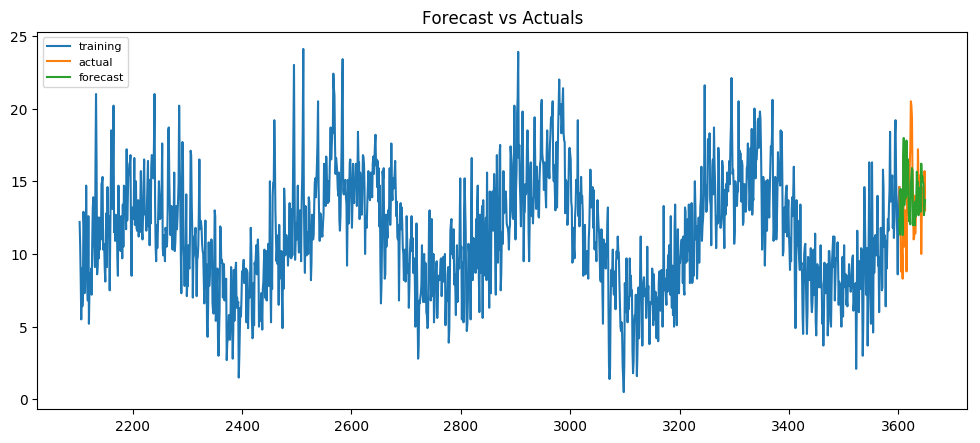

In [101]:
train = temperature.Temp[:len(temperature.Temp)-47]; test = temperature.Temp[len(temperature.Temp)-48:];
xtrain, ytrain = split_dataset(train,12) 
model = model_design_LSTM(xtrain, ytrain, 12)
plot_prediction_LSTM(predict_LSTM(xtrain, model, 12, 48), test)

In [102]:
print(metrics_LSTM(predict_LSTM(xtrain, model, 12, 48), test))

{'mpe': 0.07624002158754167, 'mae': 2.279875346024831, 'rmse': 2.9276955137163525}


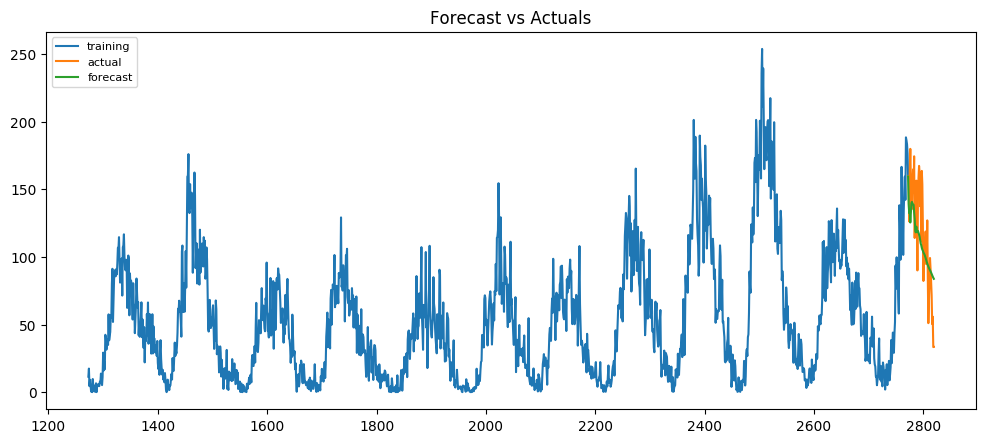

In [79]:
train = sunspot.Sunspots[:len(sunspot.Sunspots)-47]; test = sunspot.Sunspots[len(sunspot.Sunspots)-48:];
xtrain, ytrain = split_dataset(train,12) 
model = model_design_LSTM(xtrain, ytrain, 12)
plot_prediction_LSTM(predict_LSTM(xtrain, model, 12, 48), test)

In [80]:
print(metrics_LSTM(predict_LSTM(xtrain, model, 12, 48), test))

{'mpe': 0.041297526361741166, 'mae': 22.80664211908976, 'rmse': 28.15724647669251}
